# Decoder models - GPT

In the previous chapters, we learned about the transformer architecture and its building blocks, the encoder and the decoder. The last chapter demonstrated how the encoder can be used to create meaningful numerical representations of text. These representations are able to understand and incorporate meaning and context of tokens. The encoder models are pre-trained by tasks such as masked token, next sentence or replaced token prediction. After pre-training, the models can be fine-tuned for specific tasks such as regression or classification. Usually pre-training is done with a large corpus of different text sources, while fine-tuning can achieve impressive results with relatively small data sets.

In addition to encoder models, also decoder models have been developed and were the spark for text generating technologies which accompany most of our lives nowadays. Even though, decoder models have not been used frequently in the academic field of financial markets (at least to the best of my knowledge), they already play an important role in other fields of business, economics and information systems. Thus, towards the end of this course let us take a look at the decoder model. Hereby, we mostly are going to focus on in its basic form. Popular examples of the first models are GPT and GTP2 by [Radford et. al, 2018](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) and [Radford et. al, 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). 

As the encoder, the decoder model receives a sequence of tokens which are processed through word embedding, positional encoding and attention layers. In contrast to the encoder the attention mechanism is adjusted in an autoregressive manner which means tokens can only pay attention to its preceding tokens and not to the ones which follow after them. The pre-training is done by next token prediction. While a special token which is usually positioned in the beginning of the sequence for the BERT model, an end of sequence token can be placed at the end of each sequence for a decoder model to learn when a sequence should end. However, this is not mandatory. Nevertheless, in comparison to BERT, we may want use the numerical representation of any last token in each sequence as a representation for the whole sequence as it pays attention to all proceeding tokens in the seqeuence. 

## Forward pass through the simplest decoder model possible

Let us take a look at a very small example to understand the similarities and differences to the encoder model. The start is identical which means, a sequence is tokenized and every token gets a unique id to assign a specific word embedding to each token. Furthermore, a positional embedding is added to each token in order to include the information at which position the token is used in the sequence. As stated in the previous chapters, the positional encoding originally has been generated by sine and cosine functions, but, nowadays they are also often learned during the pre-training process. 

The example below is processing a single sequence: "financial data analytics is awesome!".

In [1]:
import torch

# this example is inspired by Josh Starmer's youtube video: https://youtu.be/C9QSpl5nmrY?si=gnOSg72dKpIrHrnS
token_to_id = {'financial' : 0,
               'data': 1,
               'analytics': 2,
               'is': 3,
               'awesome': 4,
               '!' : 5, ## |eos| = end of sequence
              }

id_to_token = dict(map(reversed, token_to_id.items()))

inputs = torch.tensor([[token_to_id["financial"], 
                        token_to_id["data"], 
                        token_to_id["analytics"], 
                        token_to_id["is"],
                        token_to_id["awesome"]]])

labels = torch.tensor([[token_to_id["data"], 
                        token_to_id["analytics"], 
                        token_to_id["is"], 
                        token_to_id["awesome"],
                        token_to_id["!"]]])

The input to the model before passing it to the decoder, is given by the sequence of token ids as shown below:

In [2]:
inputs

tensor([[0, 1, 2, 3, 4]])

The goal is to predict the next token, these are collected by the sequence of the next token ids as shown below:

In [3]:
labels

tensor([[1, 2, 3, 4, 5]])

Even though, it may look like it, the pattern is **not**:

1. Given 0 -> predict 1
2. Given 1 -> predict 2
...
5. Given 4 -> predict 5

It is going to be:

1. Given 0 -> predict 1
2. Given 0, 1 -> predict 2
...
5. Given 0, 1, 2, 3, 4 -> predict 5



For the next-prediction, we are going to optimize the parameters $\Theta$ of the decoder to maximize these probabilities for every next token in the corpus. Technically, during training we minimize the sum of negative log-probabilities:

$$
\mathcal{L} = - \sum_{t=1}^T \log P(x_t \mid x_1, x_2, \dots, x_{t-1}; \Theta)
$$

for all sequences seen by the model during training. So let us take a look how these probabilities are derived. First, we set a hidden dimension and start to initialize word and positional embeddings. The number of unique tokens in a corpus define the number of word embeddings we need. Furthermore, the sequence length defines the number of positional embeddings we need. For realistic model training, a fixed sequence size is set, e.g., 512 or 1024, and all sequences are padded or truncated to that length. In our example, the sequence length is $T = 5$ and we use a hidden dimension of $p = 3$.

In [4]:
import torch.nn as nn 
import torch

torch.manual_seed(42)

max_seq = 5
hidden_dim = 3

word_embeddings = nn.Embedding(len(token_to_id), embedding_dim=hidden_dim)
positional_embeddings = nn.Embedding(inputs.size()[1], embedding_dim=hidden_dim)

print("Word embeddings:")
word_embeddings.weight

Word embeddings:


Parameter containing:
tensor([[ 1.9269,  1.4873, -0.4974],
        [ 0.4396, -0.7581,  1.0783],
        [ 0.8008,  1.6806,  0.3559],
        [-0.6866,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516],
        [ 0.8599, -0.3097, -0.3957]], requires_grad=True)

In [5]:
print("Positional embeddings:")
positional_embeddings.weight

Positional embeddings:


Parameter containing:
tensor([[-0.4220, -1.3323, -0.3639],
        [ 0.1513, -0.3514, -0.7906],
        [-0.0915,  0.2352,  2.2440],
        [ 0.5817,  0.4528,  0.6410],
        [ 0.5200,  0.5567,  0.0744]], requires_grad=True)

Once the embeddings are initialized, we collect the ones we need from the word and positional embedding vectors. For our input sequence, we need all word embeddings except the one for the last token in the sequence ("!") and all positional embeddings. Both embeddings are matrices of shape $T \times p$ and are added: $\tilde{X} = X + P $. This step is the same as for an encoder model as well as for the full transformer model.

In [6]:
print("Word embeddings for the input sequence:")
we = word_embeddings(inputs)
we

Word embeddings for the input sequence:


tensor([[[ 1.9269,  1.4873, -0.4974],
         [ 0.4396, -0.7581,  1.0783],
         [ 0.8008,  1.6806,  0.3559],
         [-0.6866,  0.6105,  1.3347],
         [-0.2316,  0.0418, -0.2516]]], grad_fn=<EmbeddingBackward0>)

In [7]:
print("Positional embeddings for the input sequence:")
pe = positional_embeddings(inputs)
pe

Positional embeddings for the input sequence:


tensor([[[-0.4220, -1.3323, -0.3639],
         [ 0.1513, -0.3514, -0.7906],
         [-0.0915,  0.2352,  2.2440],
         [ 0.5817,  0.4528,  0.6410],
         [ 0.5200,  0.5567,  0.0744]]], grad_fn=<EmbeddingBackward0>)

In [8]:
x_tilde = we + pe
x_tilde

tensor([[[ 1.5049,  0.1550, -0.8613],
         [ 0.5909, -1.1096,  0.2877],
         [ 0.7093,  1.9158,  2.5998],
         [-0.1050,  1.0632,  1.9757],
         [ 0.2883,  0.5985, -0.1772]]], grad_fn=<AddBackward0>)

Next, as for the encoder we need query, key and value embeddings which are created by initializing the weights $W^Q, W^K, W^V$

In [9]:
torch.manual_seed(42)

query = nn.Linear(hidden_dim, hidden_dim, bias = False)
key = nn.Linear(hidden_dim, hidden_dim, bias = False)
value = nn.Linear(hidden_dim, hidden_dim, bias = False)

print("Query weights:")
print(query.weight)

print("\nKey weights:")
print(key.weight)

print("\nValue weights:")
print(value.weight)

Query weights:
Parameter containing:
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090]], requires_grad=True)

Key weights:
Parameter containing:
tensor([[-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853]], requires_grad=True)

Value weights:
Parameter containing:
tensor([[-0.2695,  0.1472, -0.2660],
        [-0.0677, -0.2345,  0.3830],
        [-0.4557, -0.2662, -0.1630]], requires_grad=True)


In the first step, we calculate the corresponding embeddings by: $Q = \tilde{X} W^Q, K = \tilde{X} W^K, V = \tilde{X} W^V$ with dimension $T \times p$ and determine the scaled dot-product scores between query and key embeddings by.

$$
\text{scores} = \left( \frac{Q K^T}{\sqrt{p}} \right)
$$

This is were it gets different to the attention mechanism of the encoder model. For the encoder these scores are activated by the softmax function such that every token can pay attention to itself and all other tokens no matter if these tokens are placed before or after it in the sequence. 

In [18]:
import numpy as np
import pandas as pd

q = query(x_tilde)
k = key(x_tilde)
scores = torch.matmul(q, k.transpose(dim0 = 1, dim1 = 2))
scaled_scores = scores / torch.tensor(hidden_dim**0.5)

print(f"Attention scores before softmax:")
tokens = ["financial", "data", "analytics", "is", "awesome"]
pd.DataFrame(scaled_scores.detach().numpy()[0], index = tokens, columns = tokens).round(4)

Attention scores before softmax:


,financial,data,analytics,is,awesome
financial,-0.1006,-0.0454,0.4507,0.3174,0.0193
data,0.2624,0.3261,-0.0700,-0.1247,-0.0466
analytics,-0.3572,-0.8620,1.8158,1.2162,0.3443
is,-0.1668,-0.4991,0.9529,0.6272,0.2043
awesome,-0.1539,-0.1977,0.2952,0.2313,0.0483


For the decoder model, attention is masked in a way such that only tokens can only pay attention to itself or to the proceeding tokens. This is like reading from left to right and is also called autoregressive attention. To achieve this, we mask the scores for the tokens which follow after the token in the current position. If you take a look in the cell below, you can see that technically this is done by replacing the original scores with small value close to zero.

In [21]:
mask = torch.tril(torch.ones((max_seq, max_seq)))
mask = mask == 0
scaled_scores = scaled_scores.masked_fill(mask=mask, value=-1e9)
print(f"Masked attention scores before softmax:")
pd.DataFrame(scaled_scores.detach().numpy()[0], index = tokens, columns = tokens).round(4)

Masked attention scores before softmax:


,financial,data,analytics,is,awesome
financial,-0.1006,-1.000000e+09,-1.000000e+09,-1.000000e+09,-1.000000e+09
data,0.2624,3.261000e-01,-1.000000e+09,-1.000000e+09,-1.000000e+09
analytics,-0.3572,-8.620000e-01,1.815800e+00,-1.000000e+09,-1.000000e+09
is,-0.1668,-4.991000e-01,9.529000e-01,6.272000e-01,-1.000000e+09
awesome,-0.1539,-1.977000e-01,2.952000e-01,2.313000e-01,4.830000e-02


If we activate these values with the softmax function (for every row), masked scaled dot-product attention scores are generated. We observe that the values for every row are in $[0, 1]$ and sum up to $1$. However, in comparison to the attention mechanism of the encoder model, the weights are only available for proceeding tokens and the token itself.

In [23]:
import torch.nn.functional as F 

attention = F.softmax(scaled_scores, dim=2)
pd.DataFrame(attention.detach().numpy()[0], index = tokens, columns = tokens)

,financial,data,analytics,is,awesome
financial,1.000000,0.000000,0.000000,0.000000,0.000000
data,0.484069,0.515930,0.000000,0.000000,0.000000
analytics,0.096256,0.058105,0.845639,0.000000,0.000000
is,0.142993,0.102566,0.438126,0.316315,0.000000
awesome,0.160823,0.153924,0.251999,0.236390,0.196864


Finally, the attention is multiplied with the value embeddings. 

In [24]:
v = value(x_tilde)
v

tensor([[[-0.1537, -0.4681, -0.5867],
         [-0.3991,  0.3304, -0.0209],
         [-0.6008,  0.4985, -1.2570],
         [-0.3408,  0.5145, -0.5573],
         [ 0.0575, -0.2277, -0.2618]]], grad_fn=<UnsafeViewBackward0>)

We can see that the first embedding (row) is only using the value embedding corresponding to the first token, the second embedding (row) is a weighted combination of the first and the second rows of the value matrix. These are the embeddings corresponding to the tokens "financial" and "data". Thus, the embedding used for "analytics" after the whole attention mechanism is applied is a combination of the value embeddings for both tokens using weights for both tokens as determined by the masked attention mechanism. Accordingly, the embedding for "analytics" is a weighted combination of "financial", "data", and "analytics" and so on. 

In [25]:
x_a = torch.bmm(attention, v)
x_a

tensor([[[-0.1537, -0.4681, -0.5867],
         [-0.2803, -0.0562, -0.2948],
         [-0.5461,  0.3957, -1.1207],
         [-0.4339,  0.3481, -0.8130],
         [-0.3068,  0.1780, -0.5976]]], grad_fn=<BmmBackward0>)

After this is done, the attention layer is completed in a similar way as the encoder model's attention layers. Layer normalization and a residual connection are added. On top of that a feed forward layer is placed, again including normalization and a residual connection. The actual model uses multi-head attention, but, besides the fact that the masked attention mechanism is used, this is identical to the encoder model. 

The output of each masked attention layer can be processed through another layer masked attention layer, however, the output dimension will always be the same: $T \times p$. Let us denote the output of the decoder' attention block by: $X^A$. To conduct next token prediction it is used as input for a multi-classification task which predicts the probabilities for the next words. In our example, we number of unique tokens is $N = 6$. Thus we need a forward layer which creates out of $p$ input neurons, $N$ output neurons which are activated with the softmax function. Once the output of the attention layer is processed through this layer, the result is as shown below. Every row returns the probabilities for the next words. For instance, with the output below, the input $financial$ would give us the highest probability prediction for "!" to be the next token which is obviously wrong. However, the same prediction would be done for the input "financial data analytics is awesome" which is right. As always, the paramters of the whole model are adjusted during training to increase probability predictions for the actual next tokens.

In [26]:
import torch.nn.functional as F
import pandas as pd

torch.manual_seed(42)

next_token_prediction = nn.Linear(hidden_dim, len(token_to_id))
probs = F.softmax(next_token_prediction(x_a), dim = 2)
pd.DataFrame(probs[0].detach().numpy(), index = ["financial", "data", "analytics", "is", "awesome"], columns = ["financial", "data", "analytics", "is", "awesome", "!"])

,financial,data,analytics,is,awesome,!
financial,0.132031,0.226309,0.108338,0.158296,0.129722,0.245304
data,0.126194,0.179358,0.129261,0.182930,0.118820,0.263437
analytics,0.152013,0.130360,0.104023,0.229152,0.085190,0.299262
is,0.146018,0.140654,0.113094,0.215067,0.094568,0.290599
awesome,0.141297,0.161098,0.117462,0.195718,0.106899,0.277526


## GPT2

Let us take a look, how this looks like for an actual model. Below we import the original gpt2 model and its tokenizer and play around with a news sentence regarding Nvdia.

In [27]:
from transformers import GPT2LMHeadModel, AutoTokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

sequence = "The shares of IonQ Inc. and other companies linked to quantum computing tumbled in premarket trading on Wednesday, after Nvidia Corp. Chief Executive Officer Jensen Huang said that “very useful” quantum computers are likely decades away"

print(sequence)

The shares of IonQ Inc. and other companies linked to quantum computing tumbled in premarket trading on Wednesday, after Nvidia Corp. Chief Executive Officer Jensen Huang said that “very useful” quantum computers are likely decades away


This is how the sequence is tokenized.

In [28]:
import torch.nn.functional as F

inputs = tokenizer(sequence, return_tensors="pt")
for id in inputs["input_ids"]:
    print(tokenizer.convert_ids_to_tokens(id))

outputs = model(**inputs)
logits = outputs.logits
probs = F.softmax(logits, dim = 2)

['The', 'Ġshares', 'Ġof', 'ĠIon', 'Q', 'ĠInc', '.', 'Ġand', 'Ġother', 'Ġcompanies', 'Ġlinked', 'Ġto', 'Ġquantum', 'Ġcomputing', 'Ġt', 'umbled', 'Ġin', 'Ġpre', 'market', 'Ġtrading', 'Ġon', 'ĠWednesday', ',', 'Ġafter', 'ĠNvidia', 'ĠCorp', '.', 'ĠChief', 'ĠExecutive', 'ĠOfficer', 'ĠJensen', 'ĠHuang', 'Ġsaid', 'Ġthat', 'ĠâĢ', 'ľ', 'very', 'Ġuseful', 'âĢ', 'Ŀ', 'Ġquantum', 'Ġcomputers', 'Ġare', 'Ġlikely', 'Ġdecades', 'Ġaway']


This is what the model receives. These are the ids of the tokens from the cell above.

In [29]:
inputs["input_ids"]

tensor([[  464,  7303,   286, 36404,    48,  3457,    13,   290,   584,  2706,
          6692,   284, 14821, 14492,   256, 11137,   287,   662, 10728,  7313,
           319,  3583,    11,   706, 27699, 11421,    13,  5953, 10390, 10391,
         32623, 31663,   531,   326,   564,   250,   548,  4465,   447,   251,
         14821,  9061,   389,  1884,  4647,  1497]])

The model has already been trained, so let us take a look for a few predictions. Below we present the beginning of the sequence to the model.

In [30]:
print("Input to the model:")
print(tokenizer.decode(inputs["input_ids"][0][:11].tolist()))

Input to the model:
The shares of IonQ Inc. and other companies linked


If we process through the model, we receive a vector of size $50257$ which is the number of unique terms used by the model.

In [31]:
logits[0, 11, :].shape

torch.Size([50257])

Below are five tokens with the highest probabilities:

In [32]:
top_ids = logits[0, 11, :].argsort().flip(0)[:5]

print("Input to the model:")
print("-"*50)
print(tokenizer.decode(inputs["input_ids"][0][:11].tolist()))

print("\nMost likely tokens which could follow:")
print("-"*50)
for id, prob in zip(top_ids.tolist(), probs[0, 11, top_ids]):
    print(f"{tokenizer.decode([id])} with probability: {prob:.4f}")

Input to the model:
--------------------------------------------------
The shares of IonQ Inc. and other companies linked

Most likely tokens which could follow:
--------------------------------------------------
 the with probability: 0.3923
 its with probability: 0.0377
 Ion with probability: 0.0170
 a with probability: 0.0169
 it with probability: 0.0168


As you can see, the model does not correctly predict the next token, however, "the" would seem to a reasonable next token to me as well. Let us try one more.

In [33]:
print("Input to the model:")
print(tokenizer.decode(inputs["input_ids"][0][:13].tolist()))

Input to the model:
The shares of IonQ Inc. and other companies linked to quantum


In [34]:
top_ids = logits[0, 13, :].argsort().flip(0)[:5]

print("Input to the model:")
print("-"*50)
print(tokenizer.decode(inputs["input_ids"][0][:13].tolist()))

print("\nMost likely tokens which could follow:")
print("-"*50)
for id, prob in zip(top_ids.tolist(), probs[0, 13, top_ids]):
    print(f"{tokenizer.decode([id])} with probability: {prob:.4f}")

Input to the model:
--------------------------------------------------
The shares of IonQ Inc. and other companies linked to quantum

Most likely tokens which could follow:
--------------------------------------------------
 are with probability: 0.1440
 have with probability: 0.1428
 were with probability: 0.0638
, with probability: 0.0579
 and with probability: 0.0379


Again, not the exact next token, however, reasonable as well. This is more or less the desired outcome of a pre-trained generator, i.e., it is able to generate reasonable and human-alike language. Given it succeeds, it understands language.

## Text generation

Once a model is trained, it becomes relatively easy to determine the probability for an observed text sequence. In general at every position $t$ in the sequence, the decoder returns the conditional probability:

$$
P(x_t \mid x_1, x_2, \dots, x_{t-1}) 
$$

with $x$ representing the tokens in the sequence. To generate text, the intuitive idea is to use the token with the highest probability as the next one. After that we move on and do the same and so on. This is called a *greedy search*. However, as we are going to find out in the cells below, greedy search does not necessarily lead to human alike texts. This is why other generation mechanisms evolved for text generation. Without going to much into the details, we study ideas based on

* greedy search
* beam search
* sampling

in the examples below.

For the following examples, the starting sequence is always: "I enjoy studying text models, because" and the model is supposed to continue the sequence up to a maximum of 40 tokens.

In the cell below, we observe the output of a greedy search and as we can see it somewhat makes sense, however, parts of the sequence tend to get repeated a lot. This may be related to the algorithms behavior of ignoring other tokens with high probabilities. Thus, the outcome of generated text is less diverse and tends to repeat at some point. 

In [43]:
from transformers import GPT2LMHeadModel, AutoTokenizer

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

sentence_start = "I enjoy studying text models, because"
inputs = tokenizer(sentence_start, return_tensors = "pt")

greedy_output = model.generate(
    **inputs,
    max_new_tokens = 40,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because they are very easy to understand and understand. I also like to use them to create a visual representation of the world.

I like to use them to create a visual representation of the world.


One way to tackle this issue is by applying *beam* search. To understand this, we need to repeat some fundamentals of probability calculus, i.e., tools to calculate probabilities for discrete sequential outcomes. Maybe you remember from school or undergraduate math or statistics courses, that the probability for the sequence "financial data analytics", given the start word is "financial" in the example below is:

$$
P(data, analytics| financial) = 0.4 \cdot 0.1 = 0.04
$$

or 

$$
P(data, analysis| financial) = 0.4 \cdot 0.9 = 0.36
$$

This comes from the general formula:

$$
P (x_{1:T} | x_0) = P(x_T | x_{0:T-1}) \cdot P(x_{T-1} | x_{0:T-2}) \cdot ... \cdot P(x_1 | x_0) = \prod_{t=1}^T P(x_t | x_{0:t-1})
$$


with $x_{1:T} = x_1, x_2, ...,x_t$ representing the sequence from token at position $t=1$ until token at position $T$. If you are interested, this formula can be derived by the chain rule of probabilities also called factorization. Given a sequence of events or random variables  $x = \{x_1, x_2, \dots, x_T\} $, its joint probability can be determined by:

$$
P(x_1, x_2, \dots, x_T) = P(x_1) \cdot P(x_2 \mid x_1) \cdot P(x_3 \mid x_1, x_2) \cdot \dots \cdot P(x_T \mid x_1, x_2, \dots, x_{T-1})
$$

Coming back to our example in the cell below, this means, we can determine the probabilities for all potential sequences, given the seed word "financial" simply by following the branches of the trees and multiplying the conditional probabilities. For our example, this gives us:

$$

P(data, analysis| financial) = 0.4 \cdot 0.9 = 0.36 \\
P(data, analytics| financial) = 0.4 \cdot 0.1 = 0.04 \\
P(analysis, is| financial) = 0.6 \cdot 0.4 = 0.24 \\
P(analysis, help| financial) = 0.6 \cdot 0.4 = 0.12 \\
P(analysis, improves| financial) = 0.6 \cdot 0.4 = 0.24 \\
$$

This means the sequence "financial data analysis" is more likely than "financial analysis is" or "financial analysis improves", even though the next token after "financial" which would be chosen according to a greedy search is "analysis". So generating the first sequence might be more reasonable and is different from greedy search. 

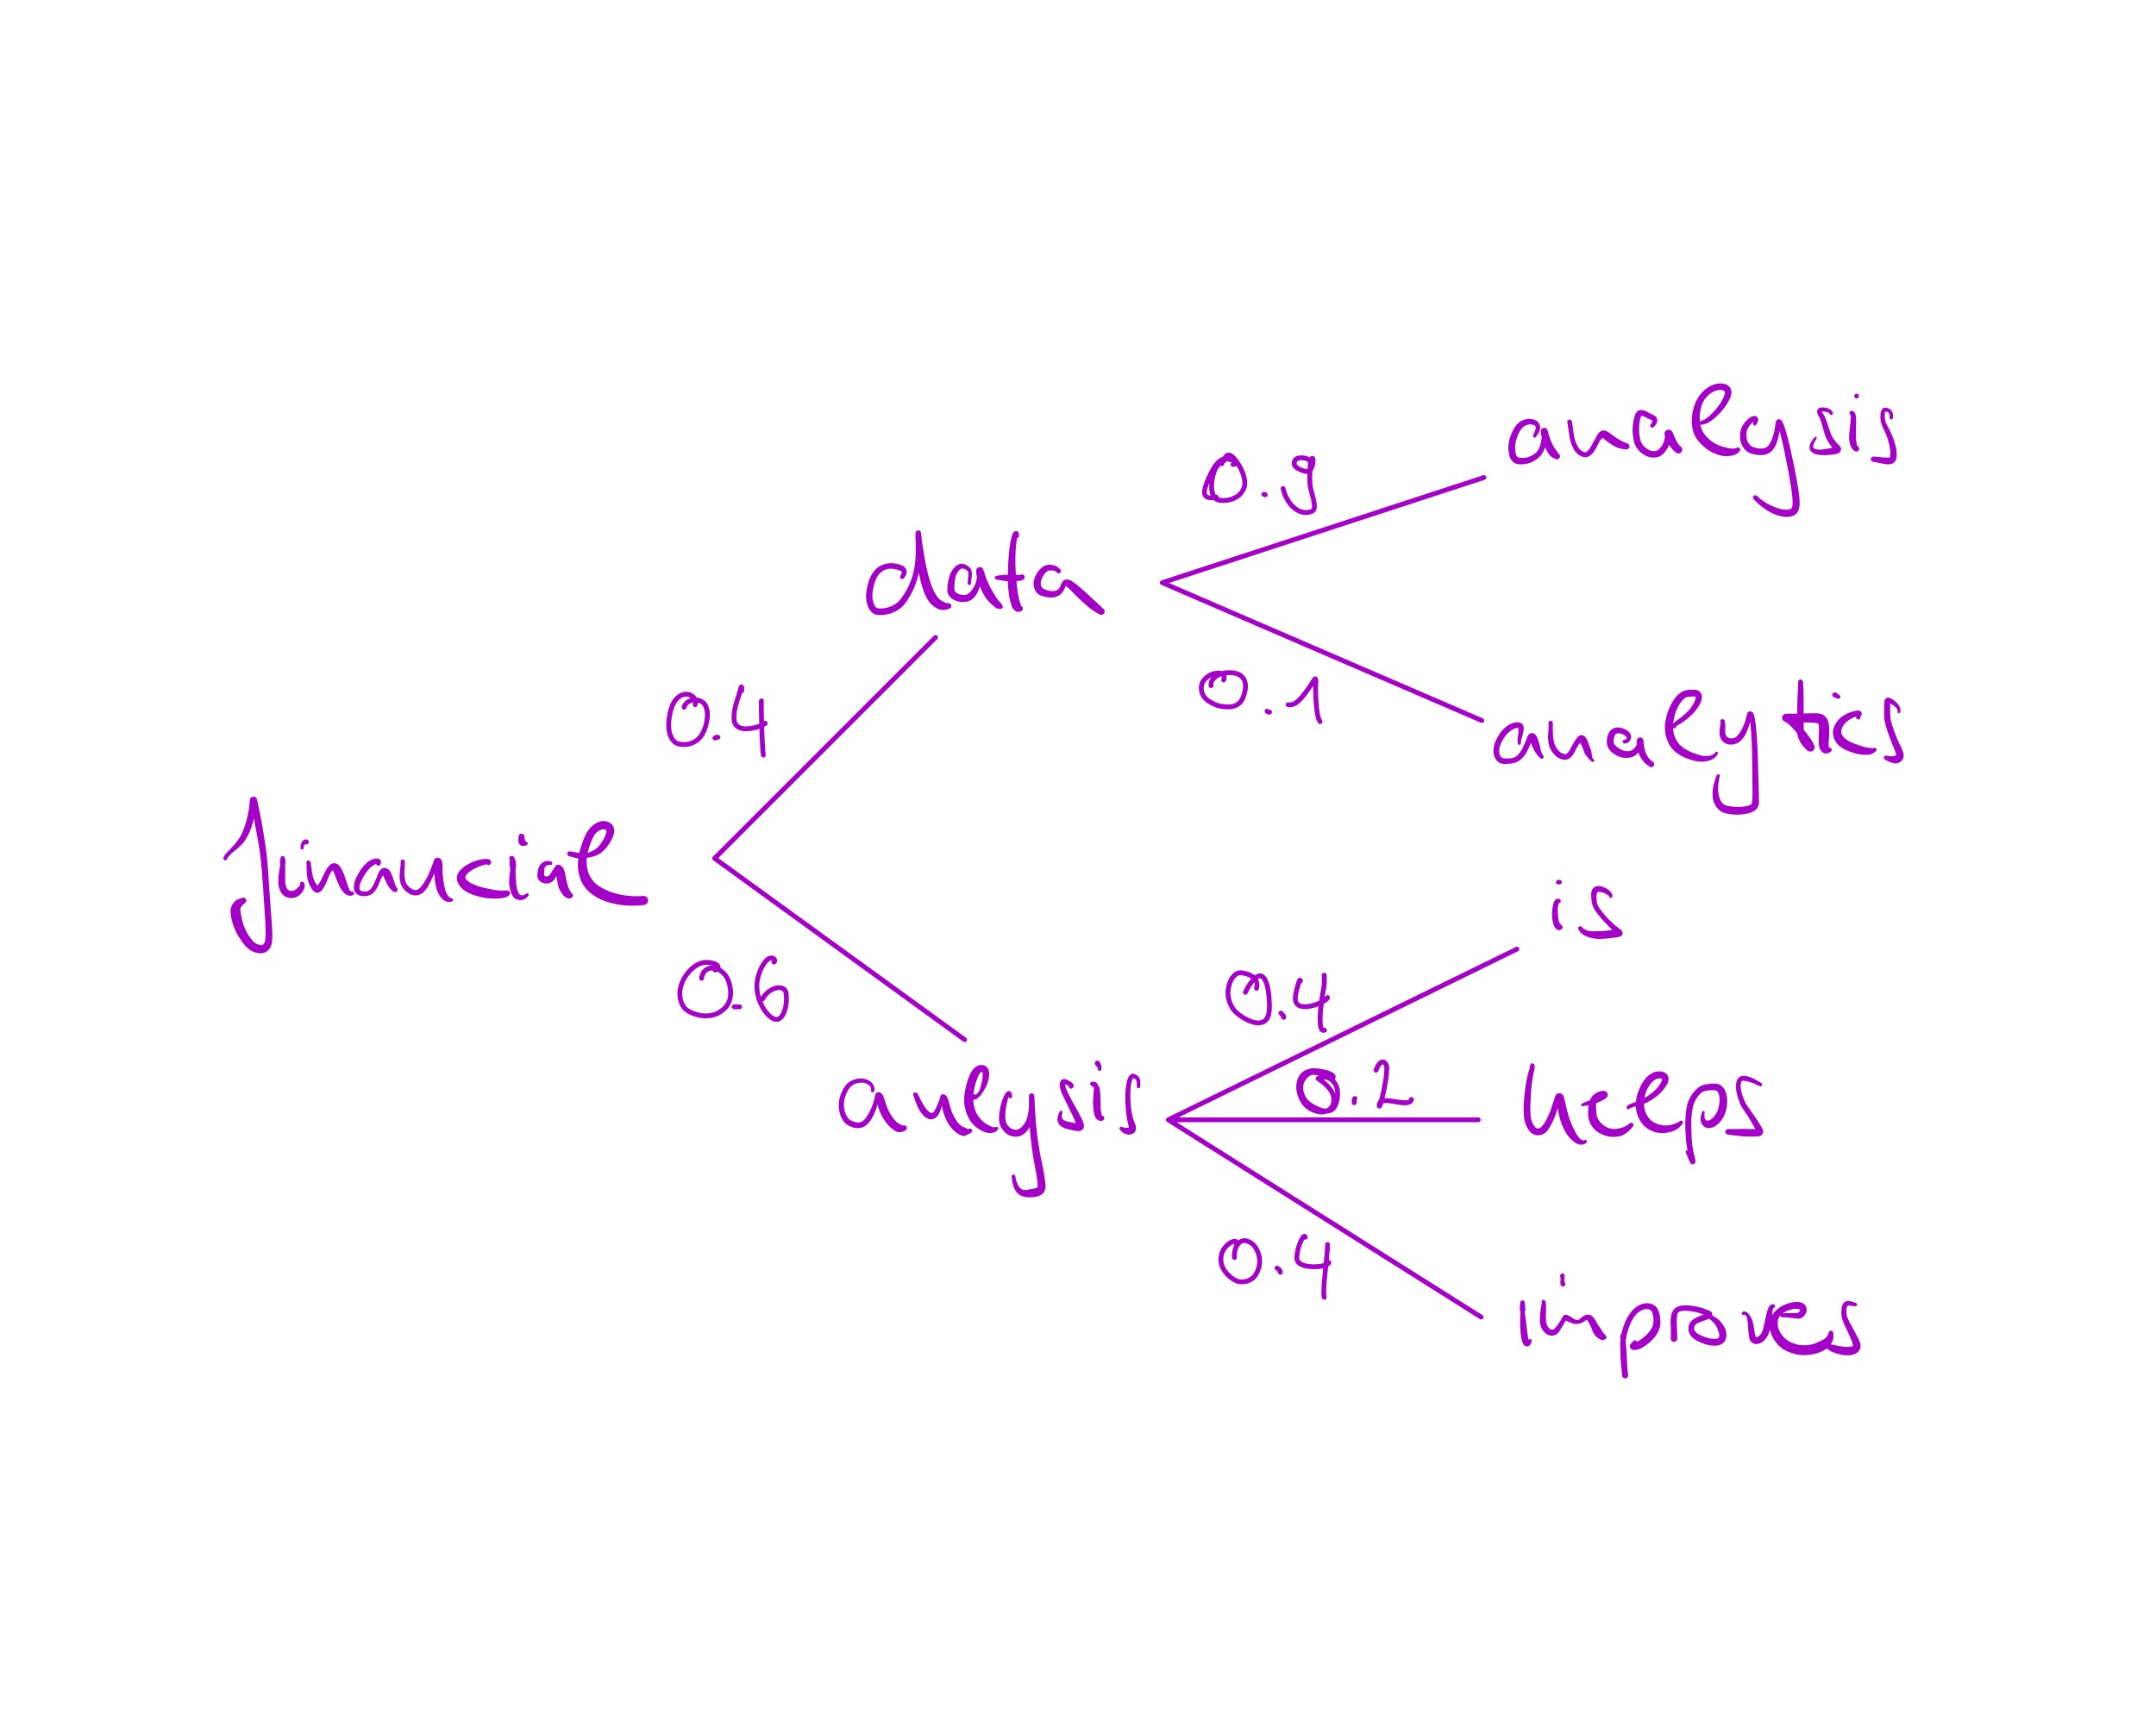

In [47]:

from IPython.display import Image
Image(filename='word_seq_probs.jpg', width=600) 

Beam search keeps track of the most likely tokens at each time step and finally choses the sequence with the highest probability overall. If we take a look at the generated text below the next cell, we hardly observe an improvement, the generated text still seems to be very repetitive. This may be improved by not allowing the algorithm to use n-grams more than once. Nevertheless, the literature further argues that human text does not necessarily mostly include high probability tokens and often may have more surprising (and by this means less likely) tokens in a sequence. 

In [49]:
beam_output = model.generate(
    **inputs,
    max_new_tokens=40,
    num_beams=5,
    early_stopping=True,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because they allow me to see what I want to see, and I can see what I want to see, and I can see what I want to see, and I can see what I want to see


To include this surprising element when generating text, we may sample tokens according to their conditional probability distribution. For instance, regarding to the probability example from above, we continue a sequence with "data" in 40\% of all generated samples and with "analysis" in 60\%. So all possible sequences may occur, however, "financial data analysis" will be the one which occurs the most. 

If we take a look how this impacts the generation of our full text sequence, at first sight it seems more natural, however, the sequence makes little sense at this point. So maybe, too much randomness?!

In [51]:
from transformers import set_seed

set_seed(42)

sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k = 0,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because I'm more proficient with models in actual conversations, because, well, like a lot of these people. BUT if they act the way I want them to and think you'd be interested in their skills


In order to overcome the issue of too much randomness, different methods can be done. These can be applied separately or in combination. 

* Temperature sampling
* Top-k sampling
* Nucleus sampling

To understand temperature sampling, we need to remember that probabilities are usually determined by activating scores via a softmax function. For instance, if we have three possible categories, the scores are:

$$
z = [1.0, 1.0, 1.2]
$$

Remember from a previous chapter that the softmax activation transformes theses scores to probabilities by:

$$
g(z_{k}) = \frac{e^{z_{k}}}{\sum_l e^{z_{l}}} 
$$

Temperature sampling adjusts scores by dividing them with temperature $c \in (0, 1]$:

$$
z^{*} = \frac{z}{c}
$$

and determines probabilities by applying the softmax activation to these scores. For temperature $c<1$, high probability tokens become more likely and low probability words become less likely. For instance, if we use the scores from above probabilities are:

In [68]:
import numpy as np

scores = np.array([1, 1, 1.2])
F.softmax(torch.tensor(np.exp(scores)), dim = 0)

tensor([0.2614, 0.2614, 0.4772], dtype=torch.float64)

Setting the temperature to $c=0.6$ changes these probabilities to:

In [69]:
t = 0.6
F.softmax(torch.tensor(np.exp(scores/t)), dim = 0)

tensor([0.0988, 0.0988, 0.8024], dtype=torch.float64)

Using this technique, we generate the following sequence.

In [82]:
from transformers import set_seed

set_seed(42)

sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    temperature = 0.6,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because I'm more proficient with them in terms of how they are applied to the text and how we can understand them.

It's also interesting because I've been doing several interviews with people who are


Top-k sampling first chooses the $k$ tokens with the highest probabilities, proportionally adjusts these probabilities and samples from that distribution. For instance in our decision tree, we have:

$$
P(x_2 | financial, analysis) = 
\begin{cases}
0.4 & is \\
0.2 & helps \\
0.4 & improves 
\end{cases}
$$

Let us set k=2, we only keep "is" and "improves" and re-adjust the conditional probability distribution to:

$$
P(x_2 | financial, analysis) = 
\begin{cases}
0.5 & is \\
0.5 & improves 
\end{cases}
$$

Using this technique, we generate the following sequence.

In [87]:
from transformers import set_seed

set_seed(42)

sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k = 25,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because I'm more comfortable with the computer world."


Or combining these techniques leads to:

In [88]:
from transformers import set_seed

set_seed(42)

sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k = 50,
    temperature = 0.8,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because I'm more proficient with them in terms of my writing, and I like to see how we can improve our research approaches. I'm also happy to help people think about the data. So I'm


The last variant we take a look at is *nucleus (top-p)* sampling. In essence, it may be seen as a refinement of top-k sampling. Instead of sample from the top-k probability tokens, we search for the smallest set of tokens such that their sum of individual probabilities exceeds $p$. For instance in our decision tree, we have:

$$
P(x_2 | financial, analysis) = 
\begin{cases}
0.4 & is \\
0.2 & helps \\
0.4 & improves 
\end{cases}
$$

Let us set p=0.7, the smallest set whose sum of individual probabilities are again the words "is" and "improves", thus, this would be equivalent to top-k sampling with $k=2$ in our example. Again the original probabilities are redistributed such that the sum of probabilities is equal to one.

$$
P(x_2 | financial, analysis) = 
\begin{cases}
0.5 & is \\
0.5 & improves 
\end{cases}
$$

Using this technique, we generate the following sequence.

In [90]:
from transformers import set_seed

set_seed(42)

sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_p = 0.95,
    pad_token_id = tokenizer.eos_token_id,
    eos_token_id = tokenizer.eos_token_id
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy studying text models, because I'm more proficient with models in languages like JavaScript or Ruby. I like to see examples of how it's possible to design the most realistic way possible for an individual program.

The more code


## Finetuning

Similar to encoder only models, the decoder models are usually finetuned for specific tasks. In general, the nature of encoder models is to create a meaningful numerical representation of the original input. The decoder models may be suited for this as well, however, due to their attention mechanism maybe better suited for tasks of text generation. 

Examples which can be tackled by both model types are regression or classification tasks. We already learned that the CLS token representation of the encoder is usually used as a representation for the whole sequence by encoder models. In case of the decoder models, this would make little sense as the first token is only able to pay attention to itself and not the sequence of tokens which follow after it. Thus, the numerical representation of the last token in the sequence is used by decoder models to represent the sequence. For this purpose, it would make sense to end every sequence with a special token, e.g., an EOS (End of Sequence) token. 

Besides tasks such as question answering or summarizing are better tackled by decoder models as they are able to create sequences of tokens with arbitrary length. Overall the process is as for encoder models. After pretraining, labeled examples are presented to the model and all its parameters are finetuned to increase the performance for a specific task. 